In [86]:
!pip install pydriller
!pip install gitpython
!pip install pandas
!pip install matplotlib
!pip install scipy


   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---- ----------------------------------- 5.5/44.5 MB 28.8 MB/s eta 0:00:02
   ------------ --------------------------- 13.4/44.5 MB 33.2 MB/s eta 0:00:01
   ------------------- -------------------- 21.5/44.5 MB 34.7 MB/s eta 0:00:01
   ----------------------- ---------------- 26.2/44.5 MB 35.2 MB/s eta 0:00:01
   ------------------------- -------------- 28.6/44.5 MB 27.3 MB/s eta 0:00:01
   --------------------------------- ------ 36.7/44.5 MB 29.0 MB/s eta 0:00:01
   ---------------------------------------  44.3/44.5 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------- 44.5/44.5 MB 26.4 MB/s eta 0:00:00


In [2]:
from pydriller import Repository 
from collections import Counter

tensorflow = 'https://github.com/tensorflow/tensorflow.git'
qbittorent = 'https://github.com/qbittorrent/qBittorrent.git'

# Lista para armazenar contribuidores únicos
contributors = set()

# Dicionário para armazenar a data do primeiro commit de cada colaborador
first_commit_dates = {}

# Conta o numero de commits por contribuidor
commit_counts = Counter()

# Iterar pelos commits do repositório
for commit in Repository(qbittorent).traverse_commits():
    contributors.add(commit.author.email)
    
    if commit.author.email not in first_commit_dates:
        first_commit_dates[commit.author.email] = commit.author_date

    commit_counts[commit.author.email] += 1


In [9]:
from git import Repo
from datetime import timedelta
import pandas as pd
import re

# Caminho para o repositório clonado localmente
repo_path = 'qBittorrent'

# Usar GitPython para acessar o repositório
repo = Repo(repo_path)

# Padrão para tags relevantes (excluindo pré-releases como beta, rc, etc.)
tag_pattern = re.compile(r"^release-\d+\.\d+\.\d+$")

# Obter uma lista de pares (nome da tag, data do commit associado)
releases = [
    (tag.name, tag.commit.committed_datetime)
    for tag in repo.tags
    if tag_pattern.match(tag.name)  # Filtrar tags que correspondem ao padrão
]

# Ordenar as releases pela data do commit
releases.sort(key=lambda x: x[1])  # Ordenar pelo segundo elemento (data)

df_releases = pd.DataFrame(columns=['Release anterior', 
                                    'Release atual',
                                    'intervalo entre as releases(dias)', 
                                    'novos colaboradores',
                                    'numero total de commits',
                                    'commits de novos colaboradores',
                                    'total de colaboradores'])

# Calcular intervalos de tempo entre releases consecutivas e exibir a tag
for i in range(1, len(releases)):
    current_tag, current_date = releases[i]
    previous_tag, previous_date = releases[i-1]
    count_new_contribuitors = 0
    count_commits = 0
    
    count_new_contribuitors = sum(
    1 for contribuitor, date in first_commit_dates.items()
    if previous_date <= date <= current_date
    )
            
    # Usar GitPython para contar os commits no intervalo
    count_commits = repo.git.rev_list('--count', f'--since={previous_date}', f'--until={current_date}','HEAD')
    count_commits = int(count_commits)  # Converta para inteiro

    # Calcular o total de colaboradores no intervalo de releases
    total_contributors = set()

    # Obter todos os commits no intervalo entre as releases
    for commit in Repository(repo_path, since=previous_date, to=current_date).traverse_commits():
        total_contributors.add(commit.author.email)  # Adiciona o colaborador à lista de colaboradores

    # Total de colaboradores que fizeram commits no intervalo
    total_contributors_count = len(total_contributors)
    
    # Identificar novos colaboradores
    new_contributors = {
        contribuitor for contribuitor, date in first_commit_dates.items()
        if previous_date <= date <= current_date
    }
    
    # Contar commits feitos por novos colaboradores
    new_contributor_commits = sum(
        1 for commit in Repository(repo_path, since=previous_date, to=current_date).traverse_commits()
        if commit.author.email in new_contributors
    )
    
    interval = current_date - previous_date
    # print(f"Intervalo entre releases '{previous_tag}' e '{current_tag}': {interval.days} dias e {count_new_contribuitors} novos colaboradores {count_commits} commits feitos ")
    new_row = {'Release anterior':previous_tag, 
               'Release atual':current_tag,
               'intervalo entre as releases(dias)':interval.days, 
               'novos colaboradores':count_new_contribuitors,
               'numero total de commits':count_commits,
               'commits de novos colaboradores':new_contributor_commits,
               'total de colaboradores':total_contributors_count}
    df_releases = pd.concat([df_releases, pd.DataFrame([new_row])],ignore_index=True)

df_releases


,Release anterior,Release atual,intervalo entre as releases(dias),novos colaboradores,numero total de commits,commits de novos colaboradores,total de colaboradores
0,release-0.9.2,release-0.9.3,27,0,53,0,2
1,release-0.9.3,release-1.0.0,339,1,644,3,3
2,release-1.0.0,release-1.1.0,111,0,132,0,1
3,release-1.1.0,release-1.1.1,0,0,1,0,1
4,release-1.1.1,release-1.1.2,15,0,9,0,1
...,...,...,...,...,...,...,...
176,release-4.6.5,release-4.6.6,84,7,107,14,18
177,release-4.6.6,release-4.6.7,29,2,35,2,9
178,release-4.6.7,release-5.0.0,12,0,13,0,3
179,release-5.0.0,release-5.0.1,28,5,65,5,14


In [10]:
pd.set_option('display.max_rows', None)
df = df_releases[(df_releases['intervalo entre as releases(dias)'] != 0) | (df_releases['numero total de commits'] != 0)]
df = df.reset_index(drop=True)
df

,Release anterior,Release atual,intervalo entre as releases(dias),novos colaboradores,numero total de commits,commits de novos colaboradores,total de colaboradores
0,release-0.9.2,release-0.9.3,27,0,53,0,2
1,release-0.9.3,release-1.0.0,339,1,644,3,3
2,release-1.0.0,release-1.1.0,111,0,132,0,1
3,release-1.1.0,release-1.1.1,0,0,1,0,1
4,release-1.1.1,release-1.1.2,15,0,9,0,1
5,release-1.1.2,release-1.1.3,9,0,14,0,1
6,release-1.1.3,release-1.1.4,19,0,21,0,1
7,release-1.1.4,release-1.2.1,66,0,90,0,2
8,release-1.2.1,release-1.3.0,55,0,138,0,1
9,release-1.3.0,release-1.3.1,12,0,21,0,1


In [42]:
df.to_csv('resultados.csv', index = False)

In [11]:
correlacoes = df['novos colaboradores'].corr(df['intervalo entre as releases(dias)'])
print(correlacoes)

0.5524624006368275


In [12]:
correlacoes = df['total de colaboradores'].corr(df['intervalo entre as releases(dias)'])
print(correlacoes)

0.5360588273888277


In [13]:
correlacoes = df['commits de novos colaboradores'].corr(df['intervalo entre as releases(dias)'])
print(correlacoes)

0.47346650000063845


In [14]:
correlacoes = df['novos colaboradores'].corr(df['numero total de commits'])
print(correlacoes)

0.5033500329762741


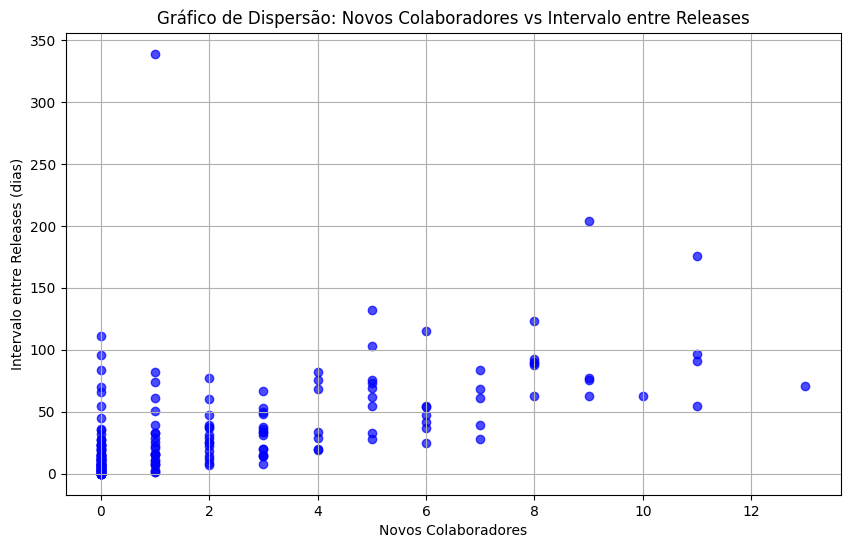

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['novos colaboradores'], df['intervalo entre as releases(dias)'], color='blue', alpha=0.7)
plt.title('Gráfico de Dispersão: Novos Colaboradores vs Intervalo entre Releases')
plt.xlabel('Novos Colaboradores')
plt.ylabel('Intervalo entre Releases (dias)')
plt.grid(True)
plt.show()

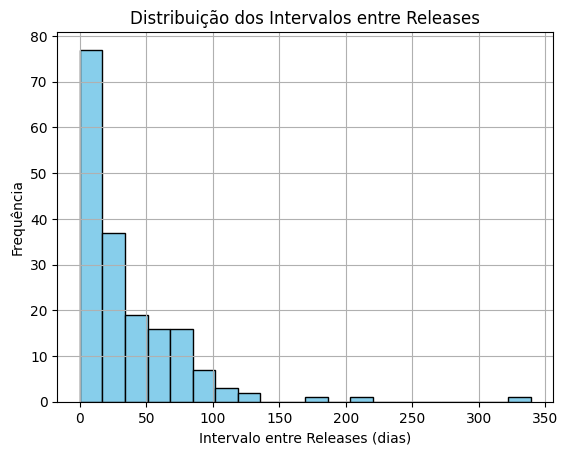

In [17]:
plt.hist(df['intervalo entre as releases(dias)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Intervalos entre Releases')
plt.xlabel('Intervalo entre Releases (dias)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

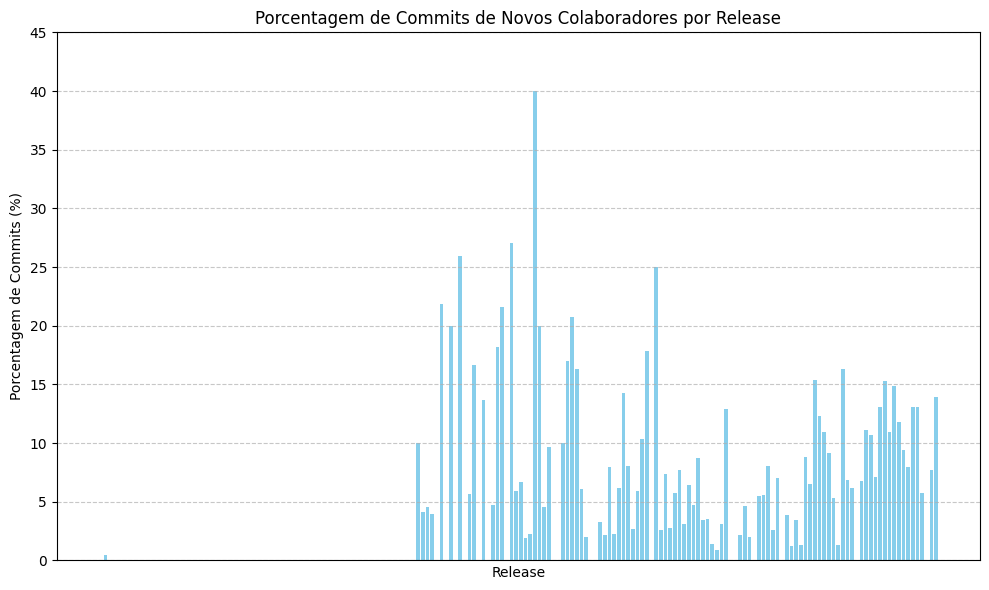

In [24]:
df['Porcentagem de commits de novos colaboradores'] = (df['commits de novos colaboradores'] / df['numero total de commits']) * 100

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['Release atual'], df['Porcentagem de commits de novos colaboradores'], color='skyblue')

# Configurações do gráfico
plt.title('Porcentagem de Commits de Novos Colaboradores por Release')
plt.xlabel('Release')
plt.ylabel('Porcentagem de Commits (%)')
plt.xticks([])
plt.xticks(rotation=40)
plt.ylim(0, 45)  # Limite de 0 a 100% no eixo Y
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Exibir gráfico
plt.tight_layout()
plt.show()

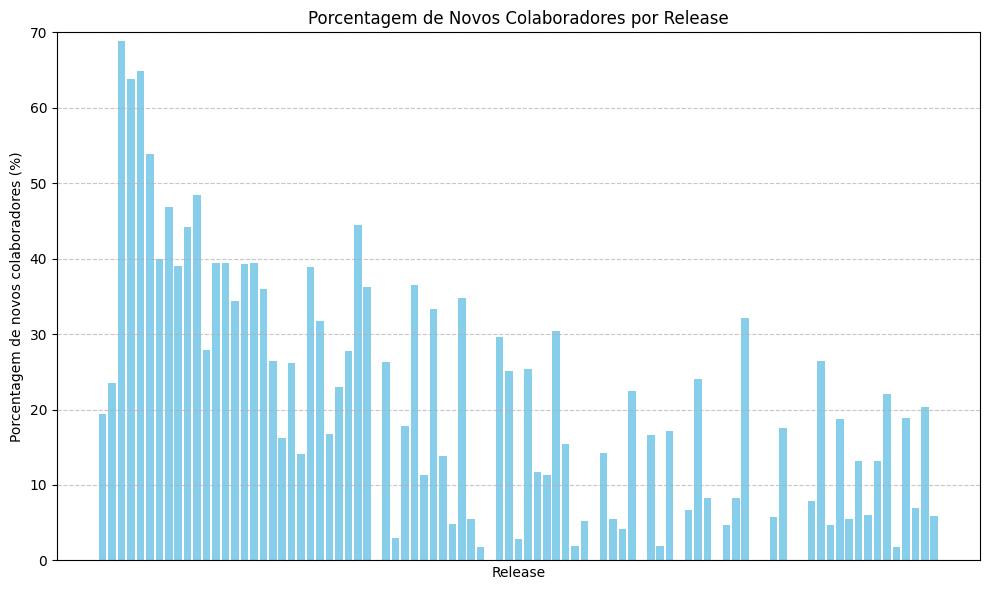

In [79]:
df['Porcentagem de novos colaboradores'] = (df['novos colaboradores'] / df['total de colaboradores']) * 100

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['Release atual'], df['Porcentagem de novos colaboradores'], color='skyblue')

# Configurações do gráfico
plt.title('Porcentagem de Novos Colaboradores por Release')
plt.xlabel('Release')
plt.ylabel('Porcentagem de novos colaboradores (%)')
plt.xticks([])
plt.xticks(rotation=45)
plt.ylim(0, 70)  # Limite de 0 a 100% no eixo Y
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Exibir gráfico
plt.tight_layout()
plt.show()

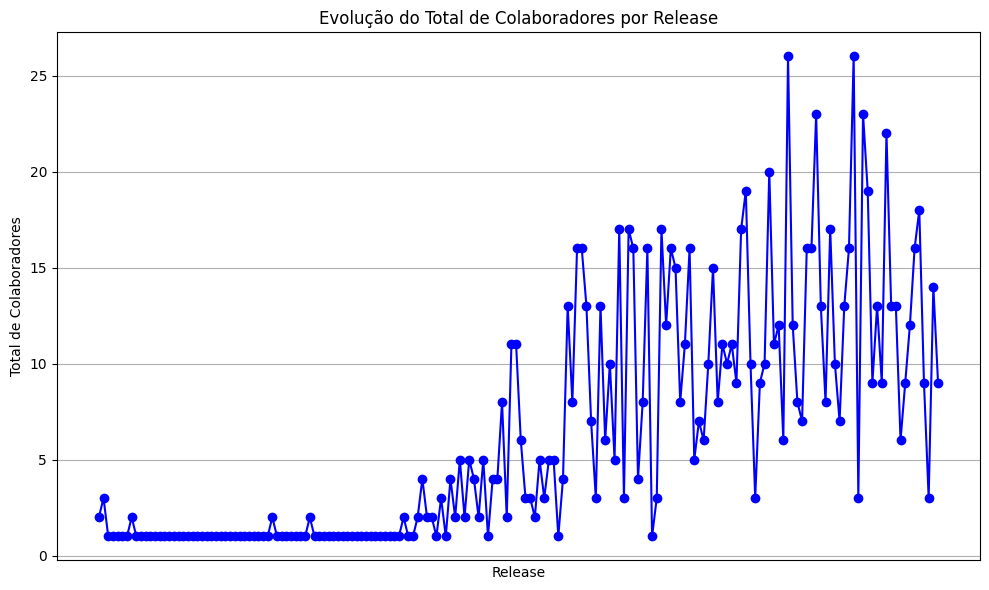

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df['Release atual'], df['total de colaboradores'], marker='o', linestyle='-', color='blue')

# Configurações do gráfico
plt.title('Evolução do Total de Colaboradores por Release')
plt.xlabel('Release')
plt.ylabel('Total de Colaboradores')
plt.xticks([])
plt.xticks(rotation=45)  # Rotaciona as labels do eixo X para melhor visualização
plt.grid(True)  # Adiciona grade ao gráfico
plt.tight_layout()

# Exibir gráfico
plt.show()

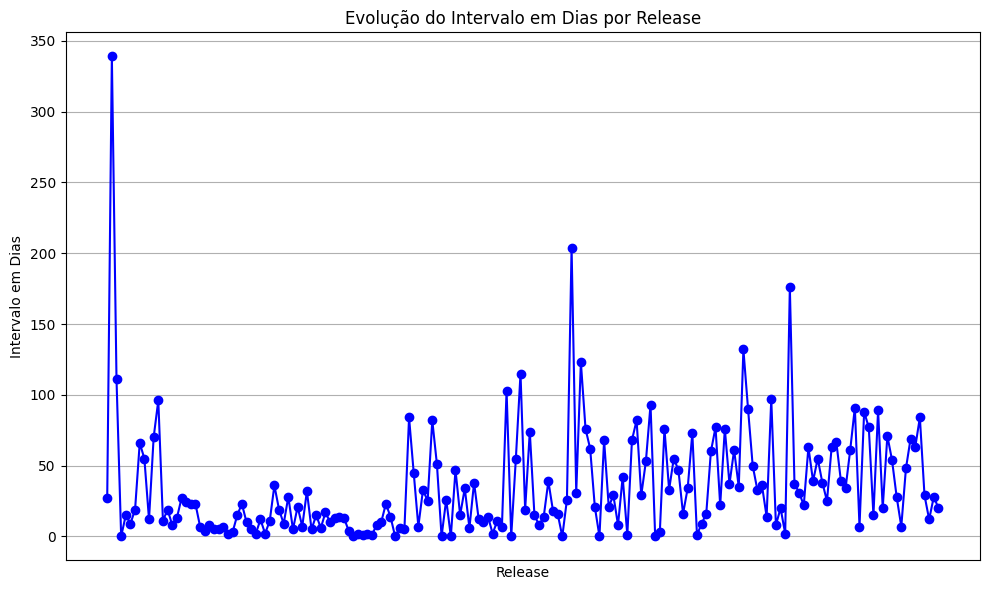

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df['Release atual'], df['intervalo entre as releases(dias)'], marker='o', linestyle='-', color='blue')

# Configurações do gráfico
plt.title('Evolução do Intervalo em Dias por Release')
plt.xlabel('Release')
plt.ylabel('Intervalo em Dias')
plt.xticks([])
plt.xticks(rotation=45)  # Rotaciona as labels do eixo X para melhor visualização
plt.grid(True)  # Adiciona grade ao gráfico
plt.tight_layout()

# Exibir gráfico
plt.show()